# Note 2: Model Validation in Hyperparameter Tuning

## 0. Overview

Hyperparameters in a predictive model are parameters whose values are manually set prior to the training. Inappropriate values of hyperparameters can lead to poor performance of the model. Hence, tuning and validating the hyperparameters is as important as training the model itself.

When it comes to model validation, a mere train-test split is sometimes insufficient. This is because when we use the test set to tune the hyperparameters, we already leak information from the test set into the model. This is a form of overfitting, and it can lead to over-estimation of the model's predictability.

To avoid this, the original training set need to be further split into a training set and a validation set. The model is trained on the training set, and the hyperparameters are tuned based on the performance on the validation set. Finally, the model's performance is evaluated on the test set. This validation process is more robust for those hyperparameters that are sensitive to the training data.

Examples of models with hyperparameters include:

- **Ridge regression** and **Lasso regression**: the regularization parameter $\lambda$.

$$
\begin{align}

\hat{\beta}^{\text{ridge}} &= \arg\min_{\beta} \left\{ \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^p \beta_j^2 \right\} \\
\hat{\beta}^{\text{lasso}} &= \arg\min_{\beta} \left\{ \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^p |\beta_j| \right\}

\end{align}
$$

- **Partial least squares regression**: the number of components.

- **Random forest**: the number of trees, the number of features to consider when looking for the best split, and the maximum depth of the tree (there are more hyperparameters, but these are the most common ones).

- **Artificial neural network**: the number of hidden layers/blocks, the number of neurons in each hidden layer/block, the activation function, the learning rate, the batch size, the number of epochs, etc.

As we did in the previous note, we need to import the following libraries first

In [1]:
import numpy as np # linear algebra, use `np`as the alias
import pandas as pd # data processing, use `pd` as the alias
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt # native visualization
import seaborn as sns # visualization but more friendly interface

## 1. Tuning a random forest model

In this note, we will use a random forest model as an example to demonstrate the process of hyperparameter tuning and validation. Random forest is a popular ensemble learning method that combines predictions from multiple smaller models (i.e., decision trees in this case) to improve the overall performance. We will use this model to solve a classification problem in this note.

### 1.1 Data overview

We will use the Iris dataset, which is a multiclass classification problem. The goal in this dataset is to predict the species of an iris flower based on the sepal length, sepal width, petal length, and petal width. The dataset contains 150 observations, and each observation has 4 features and 1 label. The label is one of the three species of iris flowers: setosa, versicolor, and virginica.

<img src="res/note02_iris.png" width="300">

Photo credit: [DAVID ILIFF](https://en.wikipedia.org/wiki/Iris_%28plant%29#/media/File:Iris_germanica_(Purple_bearded_Iris),_Wakehurst_Place,_UK_-_Diliff.jpg)

Data information: https://en.wikipedia.org/wiki/Iris_flower_data_set

Matrix dimension of X:  (150, 4)
Matrix dimension of y:  (150,)


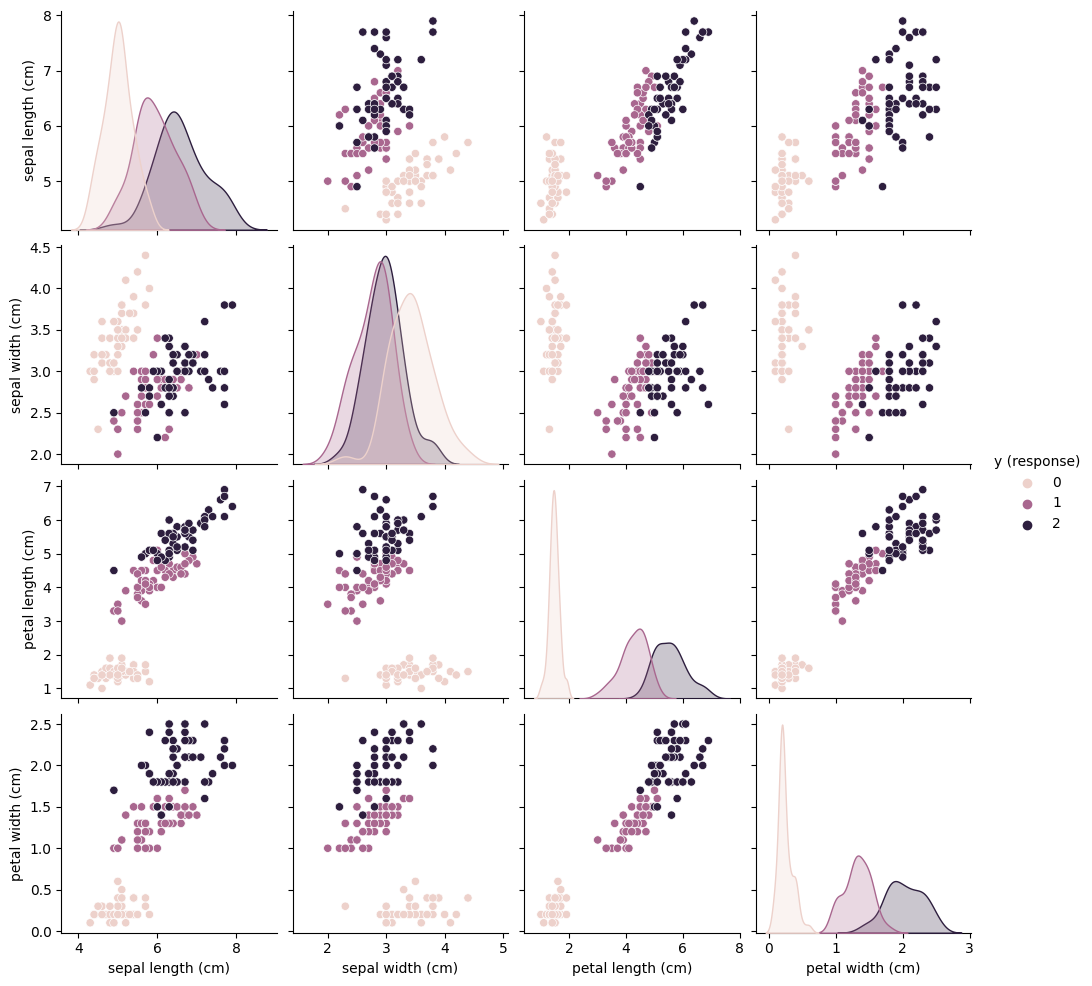

In [2]:
# load the iris dataset
data = load_iris()
X = data['data']
y = data['target']
print("Matrix dimension of X: ", X.shape)
print("Matrix dimension of y: ", y.shape)
# organize into a dataframe
df = pd.DataFrame(X, columns=data['feature_names'])
df['y (response)'] = y
sns.pairplot(df, hue="y (response)")

### 1.2 Random Forest and the hypothesis

The random forrest model has several hyperparameters, but we only focus on two of them:

1. `n_estimators`: the number of trees in the forest.
2. `max_depth`: the maximum depth of the tree.

We hypothesized that changing these two hyperparameters will significantly affect the accuracy of the model. Let's grid search these two hyperparameters and see if we can find a significant difference.

$$
\begin{cases}

    H_0: \mathbf{acc_{best}} (\mathbf{y}, \mathbf{\hat{y}}) =
     \mathbf{acc_{worst}} (\mathbf{y}, \mathbf{\hat{y}})\\

    H_1: \mathbf{acc_{best}} (\mathbf{y}, \mathbf{\hat{y}}) \neq \mathbf{acc_{worst}} (\mathbf{y}, \mathbf{\hat{y}})

\end{cases}
$$

Where $\mathbf{acc_{best}}$ and $\mathbf{acc_{worst}}$ are the accuracies of the model with the best and worst hyperparameters, respectively. $\mathbf{y}$ is the true label, and $\mathbf{\hat{y}}$ is the predicted label.

The accuracy is defined as the number of correct predictions divided by the total number of predictions $n$.

$$
\begin{align}

\mathbf{acc} (\mathbf{y}, \mathbf{\hat{y}}) &= \frac{(TP + TN)}{(TP + FN + FP + FN)} \\
&= \frac{1}{n} \sum_{i=1}^n \mathbb{1} (y_i = \hat{y}_i)

\end{align}
$$

Where $TP$ is the number of true positives, $TN$ is the number of true negatives, $FP$ is the number of false positives, $FN$ is the number of false negatives.

### 1.3 Grid search

We can define the search space of the hyperparameters and use grid search to find the best combination of hyperparameters. The search space is defined as follows:

In [3]:
# we will have 9 (3 by 3) combinations of hyperparameters
ls_n_estimators = [5, 100, 500]
ls_max_depth = [1, 3, 5]

Then, we can iterate through all the combinations and store the accuracy of each combination in a list `ls_results`.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
ls_results = []
for n_estimators in ls_n_estimators:
    for max_depth in ls_max_depth:
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        clf.fit(x_train, y_train)
        acc = clf.score(x_test, y_test)
        ls_results.append([n_estimators, max_depth, acc])
ls_results

[[5, 1, 0.5333333333333333],
 [5, 3, 0.9333333333333333],
 [5, 5, 0.9333333333333333],
 [100, 1, 0.5333333333333333],
 [100, 3, 0.9333333333333333],
 [100, 5, 0.9333333333333333],
 [500, 1, 0.5333333333333333],
 [500, 3, 0.9333333333333333],
 [500, 5, 0.9333333333333333]]

Visualize the results:

Text(47.25, 0.5, 'n_estimators')

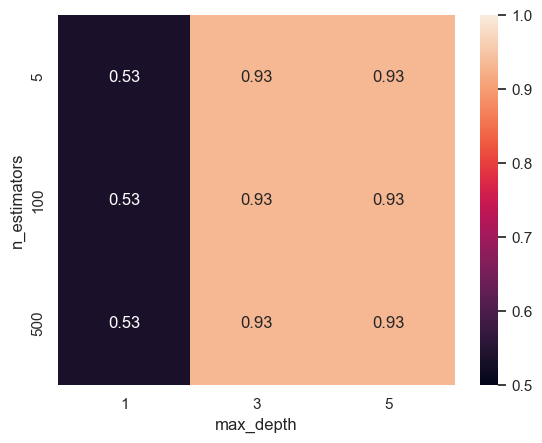

In [5]:
heatmap_data = np.array(ls_results)[:, 2].reshape(len(ls_n_estimators), len(ls_max_depth))
sns.set_theme(style="darkgrid", palette="Set2")
sns.heatmap(heatmap_data,
            vmin=0.5, vmax=1.0, annot=True,
            xticklabels=ls_max_depth, yticklabels=ls_n_estimators)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Wrap the grid search script into a function:

In [6]:
def get_acc_rf(x_train, x_test, y_train, y_test, n_estimators, max_depth):
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    clf.fit(x_train, y_train)
    acc = clf.score(x_test, y_test).round(3)
    return acc

def grid_search_rf(x_train, x_test, y_train, y_test, ls_n_estimators, ls_max_depth):
    # grid search
    ls_results = []
    for n_estimators in ls_n_estimators:
        for max_depth in ls_max_depth:
            acc = get_acc_rf(x_train, x_test, y_train, y_test, n_estimators, max_depth)
            ls_results.append([n_estimators, max_depth, acc])
    # return the results
    return np.array(ls_results)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
grid_search_rf(x_train, x_test, y_train, y_test, ls_n_estimators, ls_max_depth)

array([[  5.   ,   1.   ,   0.733],
       [  5.   ,   3.   ,   0.967],
       [  5.   ,   5.   ,   0.9  ],
       [100.   ,   1.   ,   0.9  ],
       [100.   ,   3.   ,   0.967],
       [100.   ,   5.   ,   0.933],
       [500.   ,   1.   ,   0.9  ],
       [500.   ,   3.   ,   0.933],
       [500.   ,   5.   ,   0.967]])

### 1.4 Compare the best and worst models

With result generated from the grid search function, we can compare the predictino accuracy of the best and worst models.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
result = grid_search_rf(x_train, x_test, y_train, y_test, ls_n_estimators, ls_max_depth)
best_score = np.max(result[:, 2]) # the best accuracy
worse_score = np.min(result[:, 2]) # the worse accuracy
print("The best accuracy is: ", best_score)
print("The worse accuracy is: ", worse_score)

The best accuracy is:  0.967
The worse accuracy is:  0.933


Let's expand the comparison by repeating the grid search 100 times and store the results in a list.

In [8]:
diff_maxmin = []
for _ in range(100):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    result = grid_search_rf(x_train, x_test, y_train, y_test, ls_n_estimators, ls_max_depth)
    best_score = np.max(result[:, 2])
    worse_score = np.min(result[:, 2])
    diff_maxmin.append(best_score - worse_score)

If the above script takes too long to run, you can load the results from the file `diff_maxmin.csv`.

In [9]:
diff_maxmin = pd.read_csv('out/note02_diff_maxmin.csv').loc[:, "diff"].values
diff_maxmin

array([0.433, 0.3  , 0.367, 0.033, 0.534, 0.267, 0.2  , 0.033, 0.067,
       0.367, 0.067, 0.267, 0.4  , 0.434, 0.3  , 0.434, 0.233, 0.366,
       0.2  , 0.3  , 0.4  , 0.067, 0.233, 0.067, 0.4  , 0.533, 0.4  ,
       0.3  , 0.4  , 0.067, 0.033, 0.   , 0.066, 0.067, 0.167, 0.367,
       0.034, 0.5  , 0.267, 0.4  , 0.   , 0.233, 0.033, 0.034, 0.1  ,
       0.167, 0.033, 0.267, 0.034, 0.234, 0.5  , 0.367, 0.467, 0.   ,
       0.234, 0.366, 0.366, 0.467, 0.033, 0.367, 0.367, 0.067, 0.433,
       0.067, 0.366, 0.4  , 0.367, 0.066, 0.034, 0.166, 0.1  , 0.   ,
       0.4  , 0.033, 0.233, 0.4  , 0.3  , 0.367, 0.367, 0.3  , 0.167,
       0.4  , 0.034, 0.234, 0.067, 0.5  , 0.4  , 0.034, 0.3  , 0.2  ,
       0.1  , 0.3  , 0.067, 0.4  , 0.367, 0.3  , 0.033, 0.334, 0.034,
       0.333])

And we can see how many times the best model outperforms the worst model.

In [10]:
np.sum(np.array(diff_maxmin) > 0)

96

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1.0)

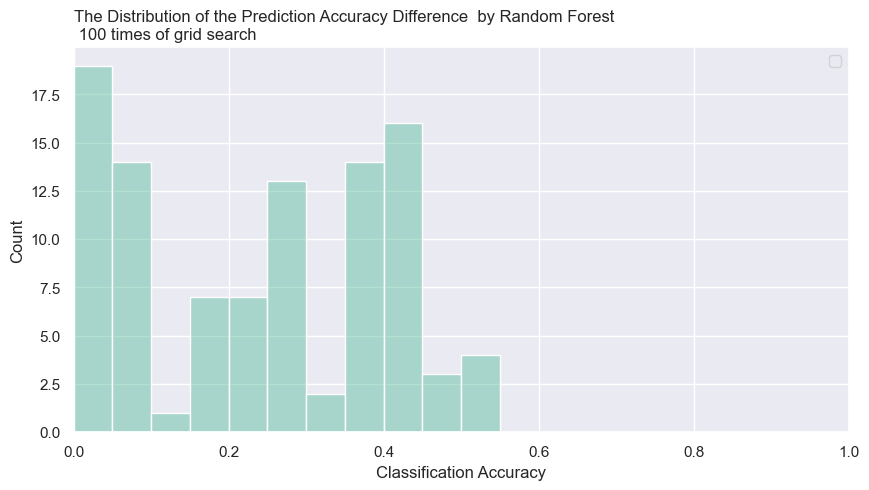

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(diff_maxmin, binwidth=.05, alpha=0.5)

# post-process the plot
plt.title("The Distribution of the Prediction Accuracy Difference  by Random Forest \n 100 times of grid search", loc="left")
plt.legend()
plt.xlabel("Classification Accuracy")
plt.xlim(0, 1)

## 2. Validating the model

### 2.1 Train-validation-test split

We have shown that there is a significant difference between different configurations of hyperparameters. In addition to the test set that can only be used for the final evaluation, we need another data split to validate the best hyperparameters. This split is called the validation set. The split proportions can vary. In this note, we first split the data into 80% training set and 20% testing set, and we then further split the 80% training set into 64% (80% of 80%) training set and 16% (20% of 80%) validation set.

<img src="res/note02_hyperparam.png" width="800">

In [12]:
# load the entire dataset
data = load_iris()
X = data['data']
y = data['target']

In [13]:
np.random.seed(24060)
# split the entire dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# further split the training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
# examine the dimension of the training, validation, and testing sets
print("Dimension of the training set: ", x_train.shape)
print("Dimension of the validation set: ", x_val.shape)
print("Dimension of the testing set: ", x_test.shape)

Dimension of the training set:  (96, 4)
Dimension of the validation set:  (24, 4)
Dimension of the testing set:  (30, 4)


### 2.2 Tuning the hyperparameters

We can use the training set and validation set to tune the hyperparameters. The process is similar to the grid search, but we only use the training set and validation set to evaluate the performance of each combination of hyperparameters. The test set is only used for the final evaluation.

In [16]:
# we will have 9 (3 by 3) combinations of hyperparameters
ls_n_estimators = [5, 100, 500]
ls_max_depth = [1, 3, 5]

# grid search
np.random.seed(24061)
ls_results = []
for n_estimators in ls_n_estimators:
    for max_depth in ls_max_depth:
        acc = get_acc_rf(x_train, x_val, y_train, y_val, n_estimators, max_depth)
        ls_results.append([n_estimators, max_depth, acc])
ls_results

[[5, 1, 0.917],
 [5, 3, 0.917],
 [5, 5, 0.875],
 [100, 1, 0.875],
 [100, 3, 0.833],
 [100, 5, 0.875],
 [500, 1, 0.833],
 [500, 3, 0.875],
 [500, 5, 0.875]]

Visualization

Text(47.25, 0.5, 'n_estimators')

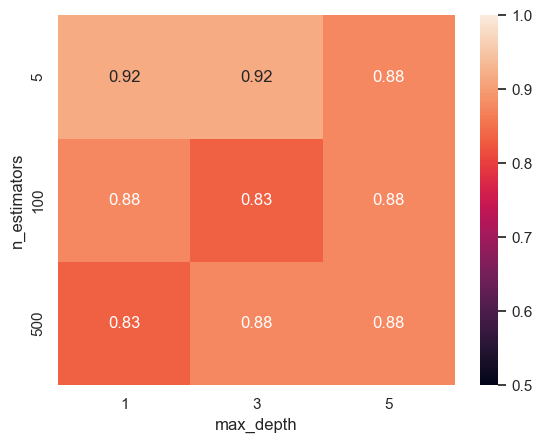

In [17]:
heatmap_data = np.array(ls_results)[:, 2].reshape(len(ls_n_estimators), len(ls_max_depth))
sns.set_theme(style="darkgrid", palette="Set2")
sns.heatmap(heatmap_data,
            vmin=0.5, vmax=1.0, annot=True,
            xticklabels=ls_max_depth, yticklabels=ls_n_estimators)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Based on the grid search results, we can see that the best combination of hyperparameters is `n_estimators=5` and `max_depth=1` or `3`. Let's train a model with these hyperparameters and evaluate the performance on the test set.

### 2.3 Final evaluation

We will choose `n_estimators=5` and `max_depth=3` as the final hyperparameters and train a model with these hyperparameters on the entire training set. Then, we can use the test set to evaluate the performance of the model with the best hyperparameters.

In [18]:
# concatenate the training and validation sets
x_train_evl = np.concatenate([x_train, x_val])
y_train_evl = np.concatenate([y_train, y_val])
print("Dimension of the training set: ", x_train_evl.shape)
print("Dimension of the testing set: ", x_test.shape)

Dimension of the training set:  (120, 4)
Dimension of the testing set:  (30, 4)


In [19]:
# train the model with the best hyperparameters
np.random.seed(24060)
final_acc = get_acc_rf(x_train=x_train_evl,
                 x_test=x_test,
                 y_train=y_train_evl,
                 y_test=y_test,
                 n_estimators=5,
                 max_depth=3)
final_acc

0.967

We have the final evaluation result, 0.967, based on the test set. This should be the evaluation result we report in the paper when the study model has hyperparameters that need to be tuned.

### 2.4 Comparison between the two validation methods

Now, let's compare the results from the two validation methods we have discussed so far. The first method uses the training set to train the model, and the testing set is used to benchmark each combination of hyperparameters. The best performance among these combinations is directly reported as the final validation result.

The second method, on the other hand, further splits the training set into a training set and a validation set. The training set is used to train the model, and the validation set used to benchmark each combination of hyperparameters. Only when the best hyperparameters are found, the model is trained on the entire training set (including the validation set). Finally, the final performance can be obtained by evaluating the model on the testing set.

In [20]:
def val_method1(x_train, x_test, y_train, y_test, ls_n_estimators, ls_max_depth):
    # grid search the entire dataset
    result = grid_search_rf(x_train, x_test, y_train, y_test, ls_n_estimators, ls_max_depth)
    # find the best hyperparameters
    idx_best = np.argmax(result[:, 2])
    n_estimators_best, max_depth_best = result[idx_best, :2]
    # final evaluation
    final_acc = get_acc_rf(x_train=x_train,
                           x_test=x_test,
                           y_train=y_train,
                           y_test=y_test,
                           n_estimators=int(n_estimators_best),
                           max_depth=int(max_depth_best))
    # report
    return final_acc

def val_method2(x_train, x_test, y_train, y_test, ls_n_estimators, ls_max_depth):
    # split the entire dataset into training and testing sets
    x_train_s, x_val, y_train_s, y_val = train_test_split(x_train, y_train, test_size=0.2)
    # grid search the entire dataset
    result = grid_search_rf(x_train_s, x_val, y_train_s, y_val, ls_n_estimators, ls_max_depth)
    # find the best hyperparameters
    idx_best = np.argmax(result[:, 2])
    n_estimators_best, max_depth_best = result[idx_best, :2]
    # final evaluation
    final_acc = get_acc_rf(x_train=x_train,
                            x_test=x_test, # the FIRST time we use the testing set!
                            y_train=y_train,
                            y_test=y_test, # the FIRST time we use the testing set!
                            n_estimators=int(n_estimators_best),
                            max_depth=int(max_depth_best))
    # report
    return final_acc


We can run the process for 100 times and compare the results.

In [ ]:
ls_acc_method1 = []
ls_acc_method2 = []

for _ in range(100):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    acc_method1 = val_method1(x_train, x_test, y_train, y_test, ls_n_estimators, ls_max_depth)
    acc_method2 = val_method2(x_train, x_test, y_train, y_test, ls_n_estimators, ls_max_depth)
    ls_acc_method1.append(acc_method1)
    ls_acc_method2.append(acc_method2)

Again, if the script takes too long to run, you can load the results from the file `acc_val.csv`.

In [21]:
data = pd.read_csv("out/note02_accval.csv")
ls_acc_method1, ls_acc_method2 = data.loc[:, "method1"].values, data.loc[:, "method2"].values

Visualize the results

Text(0.5, 0, 'Classification Accuracy')

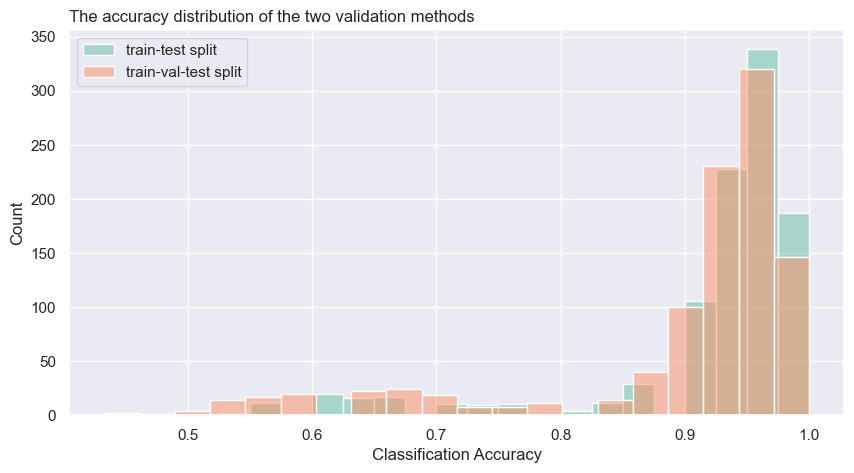

In [22]:
plt.figure(figsize=(10, 5))
sns.histplot(ls_acc_method1, bins=20, alpha=0.5, label="train-test split")
sns.histplot(ls_acc_method2, bins=20, alpha=0.5, label="train-val-test split")

# post-process the plot
plt.title("The accuracy distribution of the two validation methods", loc="left")
plt.legend()
plt.xlabel("Classification Accuracy")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Classification Accuracy')

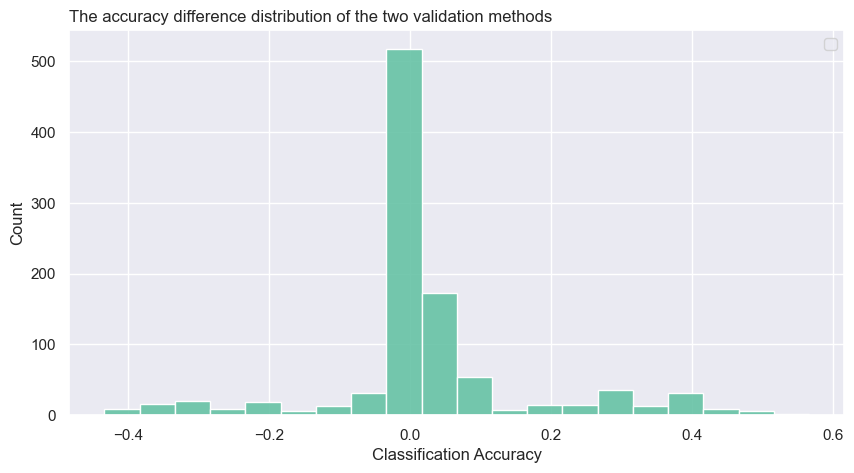

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(ls_acc_method1 - ls_acc_method2, binwidth=.05, alpha=0.9)

# post-process the plot
plt.title("The accuracy difference distribution of the two validation methods", loc="left")
plt.legend()
plt.xlabel("Classification Accuracy")